In [1]:
#STEP-1 — Load the labeled dataset again
import pandas as pd

df = pd.read_csv("data/india_states/labeled_dataset.csv")
print("Rows:", len(df))
df.head()

Rows: 953755


,location_id,location_name,sensor_id,parameter_original,parameter_display,value,unit,datetime_utc,datetime_local,latitude,...,parameter_so2,parameter_temperature,parameter_wind_direction,parameter_wind_speed,near_road,near_industry,near_farmland,near_landfill,near_dumpyard,pollution_source
0,17,"R K Puram, Delhi - DPCC",12234784,no2,NO₂,110.20,ppb,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,False,False,False,1,0,0,0,1,Natural / Background
1,17,"R K Puram, Delhi - DPCC",12234782,co,CO,3.85,ppb,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,False,False,False,1,0,0,0,1,Waste-Burning
2,17,"R K Puram, Delhi - DPCC",12234790,temperature,Temperature (C),17.50,c,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,True,False,False,1,0,0,0,1,Natural / Background
3,17,"R K Puram, Delhi - DPCC",12234788,relativehumidity,RH,78.00,%,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,False,False,False,False,1,0,0,0,1,Natural / Background
4,17,"R K Puram, Delhi - DPCC",12234789,so2,SO₂,3.50,ppb,2025-11-24 13:00:00+00:00,2025-11-24T18:30:00+05:30,28.563262,...,True,False,False,False,1,0,0,0,1,Natural / Background


STEP-2 — Re-create features & target

In [3]:
feature_cols = [
    'value', 'hour', 'month', 'weekday',
    'recent_spike','pm_trend_mean_3h','pm_trend_mean_6h',
    'near_road','near_industry','near_farmland','near_dumpyard','near_landfill',
    'latitude','longitude'
]

X = df[feature_cols]
y = df['pollution_source']

STEP-3 — Load & apply the same label encoder

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

STEP-4 — Train-test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

STEP-5 — Run the Decision Tree tuning code

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

dt = DecisionTreeClassifier(random_state=42)

dt_param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_rand = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    n_iter=8,
    cv=2,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

dt_rand.fit(X_train, y_train)

print("Best DT Parameters:")
print(dt_rand.best_params_)

dt_best = dt_rand.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best DT Parameters:
{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}


Evaluate Accuracy + Metrics

In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_dt = dt_best.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\nDecision Tree Accuracy: {accuracy_dt * 100:.2f}%\n")

print("Classification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))


Decision Tree Accuracy: 95.41%

Classification Report (Decision Tree):
                      precision    recall  f1-score   support

Agricultural Burning       0.90      0.93      0.92      1073
          Industrial       0.91      0.93      0.92     37008
Natural / Background       0.97      0.97      0.97    129872
           Vehicular       0.94      0.91      0.93     18445
       Waste-Burning       0.95      0.93      0.94      4353

            accuracy                           0.95    190751
           macro avg       0.94      0.93      0.93    190751
        weighted avg       0.95      0.95      0.95    190751



Confusion Matrix (Visualization)

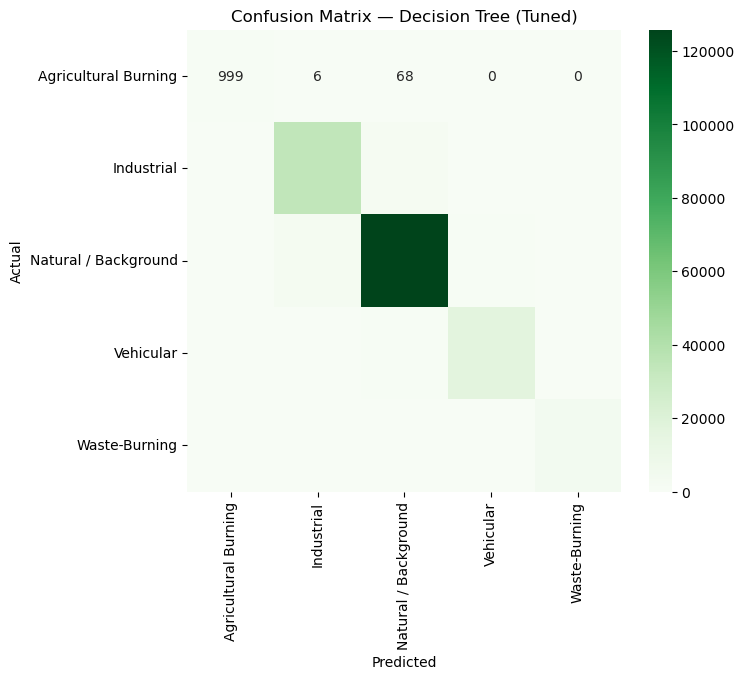

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(7,6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Decision Tree (Tuned)")
plt.show()

Save the Tuned Decision Tree Model

In [15]:
import os, joblib
os.makedirs("models", exist_ok=True)

joblib.dump(dt_best, "models/source_classifier_dt_tuned.pkl")
joblib.dump(le, "models/label_encoder.pkl")

print("Tuned Decision Tree model saved successfully")

Tuned Decision Tree model saved successfully


Feature importance


Decision Tree Feature Importance:

value               0.238583
pm_trend_mean_3h    0.159910
longitude           0.112466
latitude            0.109405
hour                0.109295
pm_trend_mean_6h    0.103743
near_industry       0.074691
near_dumpyard       0.025029
near_landfill       0.018537
weekday             0.015250
near_farmland       0.013653
month               0.010584
recent_spike        0.008854
near_road           0.000000
dtype: float64


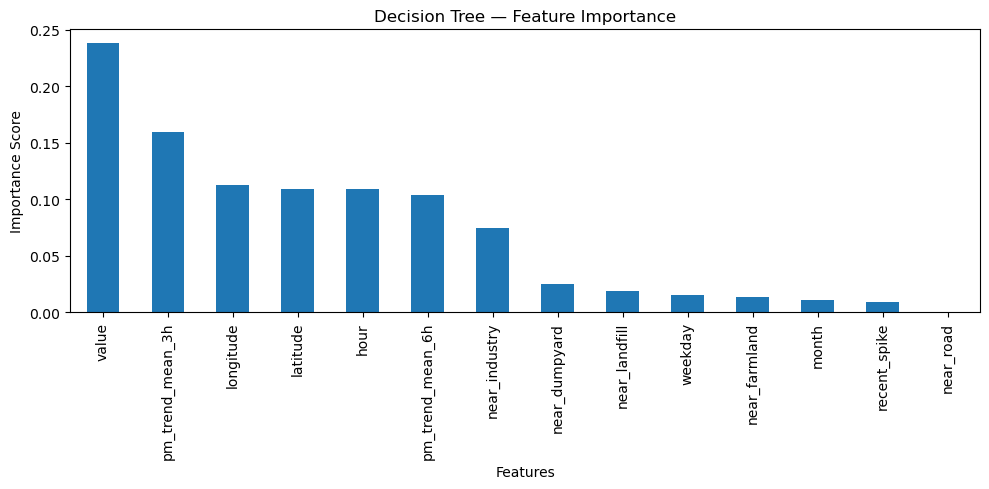

In [25]:
import pandas as pd

importances_dt = dt_best.feature_importances_
fi_dt = pd.Series(importances_dt, index=feature_cols).sort_values(ascending=False)

print("\nDecision Tree Feature Importance:\n")
print(fi_dt)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
fi_dt.plot(kind='bar')
plt.title("Decision Tree — Feature Importance")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()